# Universidad de Buenos Aires
# ViT - TP 2
# Alumno: Matias Werbin

In [1]:
# importación de librerias
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
import math
import os
import torch
from torch import Tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torch._dynamo
torch._dynamo.config.suppress_errors = True
from trainer import Trainer
from torch.utils.data import DataLoader

In [2]:
# Revisión de reconocimiento de gpu cuda
device =  'cuda' if torch.cuda.is_available() else 'cpu'
print('Dispositivo: ',device)
print('Torch version: ',torch.__version__)


Dispositivo:  cuda
Torch version:  2.5.0


In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches: int, embed_dim: int):
        super(PositionalEncodingLearned, self).__init__()
        # Incluye el +1 aquí
        self.positional_embeddings = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Añade un token de clasificación
        cls_token = torch.zeros(x.size(0), 1, x.size(-1), device=x.device)
        x = torch.cat([cls_token, x], dim=1)
        return x + self.positional_embeddings
    

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout,bias= False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
    def forward(self, x):
        return self.transformer_encoder(x)
    
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, ff_dim,
                  num_layers, num_classes, dropout, batch_first=True):
        super(VisionTransformer, self).__init__()

        # Embedding de parches
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        # Embeding posicionales
        num_patches = (img_size // patch_size) ** 2
        self.posititional_embedding = PositionalEncodingLearned(num_patches + 1 , embed_dim)

        # Token de clase
        self.cls_token = nn.Parameter(torch.rand(1,1,embed_dim))

        # Transformer Encoder
        self.transformer_encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout)

        # Cabezal de clasifficacion
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self,x):
        
        # Generamos embeddings de parches
        x = self.patch_embedding(x)

        # Añadimos token de clase
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        # Añadimos embedding posicional
        x = self.posititional_embedding(x)

        # Encoder
        x = self.transformer_encoder(x)

        cls_token_final = x[:, 0]
        output = self.classifier(cls_token_final)

        return output

In [4]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int = 3, embed_dim: int = 8):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class PositionalEncodingLearned(nn.Module):
    def __init__(self, num_patches: int, embed_dim: int):
        super(PositionalEncodingLearned, self).__init__()
        self.positional_embeddings = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.positional_embeddings

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, ff_dim: int, num_layers: int, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim, dropout=dropout, bias=False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        return self.transformer_encoder(x)

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, ff_dim,
                 num_layers, num_classes, dropout, batch_first=True):
        super(VisionTransformer, self).__init__()

        # Embedding de parches
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        # Embedding posicional
        num_patches = (img_size // patch_size) ** 2
        self.positional_embedding = PositionalEncodingLearned(num_patches, embed_dim)

        # Transformer Encoder
        self.transformer_encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, num_layers, dropout)

        # Cabezal de clasificación
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # Generamos embeddings de parches
        x = self.patch_embedding(x)

        # Añadimos embedding posicional
        x = self.positional_embedding(x)

        # Encoder
        x = self.transformer_encoder(x)

        # Promediamos todos los embeddings
        output = x.mean(dim=1)  

        # Pasar al cabezal de clasificación
        output = self.classifier(output)

        return output


In [5]:

# Definimos transformaciones (Sin Data Augmentation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

# DesCarga de CIFAR-10 con transformaciones (sin data augmentation)
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Logitud del conjunto de entrenamiento
len(train_dataset)

50000

In [9]:
# Logitud del conjunto de test
len(test_dataset)

10000

In [10]:
# Generamos un batch del Dataloader
inputs_train, targets_train = next(iter(train_loader))

In [11]:
# Revisión de batch de inputs
inputs_train.size()

torch.Size([64, 3, 32, 32])

In [12]:
# Revisión de batch de outputs
targets_train.size()

torch.Size([64])

In [13]:
# Inicialización de VisionTransformer
num_epochs = 40

model = VisionTransformer(
    img_size = 32 ,
    patch_size = 4 ,
    in_channels= 3 ,
    embed_dim= 256 , 
    num_heads= 8 , 
    ff_dim= 256 , 
    num_layers= 6 ,
    num_classes= 10,
    dropout= 0.2,
    batch_first=True
).to(device)


print("Parametros del modelo:", list(model.parameters()))

# Definición funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
model = model.to(device)

c:\Users\matia\anaconda3\envs\cuda_env\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Parametros del modelo: [Parameter containing:
tensor([[[[-0.0112, -0.0240, -0.0938, -0.1159],
          [-0.0748, -0.1198,  0.0426, -0.0587],
          [-0.1394, -0.0373, -0.0855,  0.0749],
          [ 0.0629,  0.0282,  0.0759,  0.1105]],

         [[ 0.1058,  0.0582, -0.0975,  0.1143],
          [-0.0427,  0.0929, -0.0647,  0.0759],
          [-0.1439, -0.0989, -0.1087, -0.0703],
          [-0.1435, -0.1094, -0.0869, -0.0280]],

         [[-0.1345, -0.0046, -0.0602, -0.0268],
          [ 0.1030,  0.0581,  0.0275, -0.0191],
          [-0.0106,  0.0577, -0.1132,  0.0453],
          [-0.1157, -0.0027, -0.1172,  0.1181]]],


        [[[-0.0333,  0.0262, -0.0489, -0.0365],
          [-0.0788, -0.1307,  0.1201,  0.0333],
          [-0.0327, -0.0777,  0.1138, -0.0746],
          [-0.0333,  0.0758, -0.0665,  0.1079]],

         [[ 0.0151,  0.0179, -0.0937, -0.0417],
          [ 0.0730,  0.0899, -0.1355,  0.0342],
          [ 0.0077, -0.0071, -0.1050,  0.0662],
          [-0.0224,  0.0647, -0.

In [14]:
import matplotlib.pyplot as plt

# Función de entrenamiento y evaluación
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, num_epochs):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    train_f1_scores = []
    test_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        all_train_preds = []
        all_train_targets = []

        # Entrenamiento
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

            all_train_preds.extend(predicted.cpu().numpy())
            all_train_targets.extend(targets.cpu().numpy())

        train_losses.append(train_loss / len(train_loader))
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        train_f1 = f1_score(all_train_targets, all_train_preds, average='macro')
        train_f1_scores.append(train_f1)

        # Evaluación
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        all_test_preds = []
        all_test_targets = []

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

                all_test_preds.extend(predicted.cpu().numpy())
                all_test_targets.extend(targets.cpu().numpy())

        test_losses.append(test_loss / len(test_loader))
        test_accuracy = correct / total
        test_accuracies.append(test_accuracy)
        test_f1 = f1_score(all_test_targets, all_test_preds, average='macro')
        test_f1_scores.append(test_f1)

        # Métricas
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, Train F1: {train_f1:.4f}, "
              f"Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracy:.4f}, Test F1: {test_f1:.4f}")

    # Plots
    plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, train_f1_scores, test_f1_scores)
    
# Función para graficas métricas
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, train_f1_scores, test_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, test_accuracies, label='Test Accuracy')
    plt.plot(epochs, train_f1_scores, label='Train F1 Score', linestyle='--')
    plt.plot(epochs, test_f1_scores, label='Test F1 Score', linestyle='--')
    plt.title('Accuracy and F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch [1/40], Train Loss: 1.7620, Train Acc: 0.3532, Train F1: 0.3468, Test Loss: 1.5355, Test Acc: 0.4331, Test F1: 0.4265
Epoch [2/40], Train Loss: 1.4880, Train Acc: 0.4569, Train F1: 0.4517, Test Loss: 1.4033, Test Acc: 0.4818, Test F1: 0.4661
Epoch [3/40], Train Loss: 1.3706, Train Acc: 0.5030, Train F1: 0.4983, Test Loss: 1.3338, Test Acc: 0.5140, Test F1: 0.5076
Epoch [4/40], Train Loss: 1.3004, Train Acc: 0.5309, Train F1: 0.5268, Test Loss: 1.2672, Test Acc: 0.5332, Test F1: 0.5253
Epoch [5/40], Train Loss: 1.2486, Train Acc: 0.5515, Train F1: 0.5480, Test Loss: 1.2427, Test Acc: 0.5524, Test F1: 0.5414
Epoch [6/40], Train Loss: 1.2005, Train Acc: 0.5697, Train F1: 0.5664, Test Loss: 1.1574, Test Acc: 0.5802, Test F1: 0.5709
Epoch [7/40], Train Loss: 1.1470, Train Acc: 0.5905, Train F1: 0.5875, Test Loss: 1.1665, Test Acc: 0.5865, Test F1: 0.5790
Epoch [8/40], Train Loss: 1.1046, Train Acc: 0.6055, Train F1: 0.6029, Test Loss: 1.0927, Test Acc: 0.6127, Test F1: 0.6101
Epoch [9

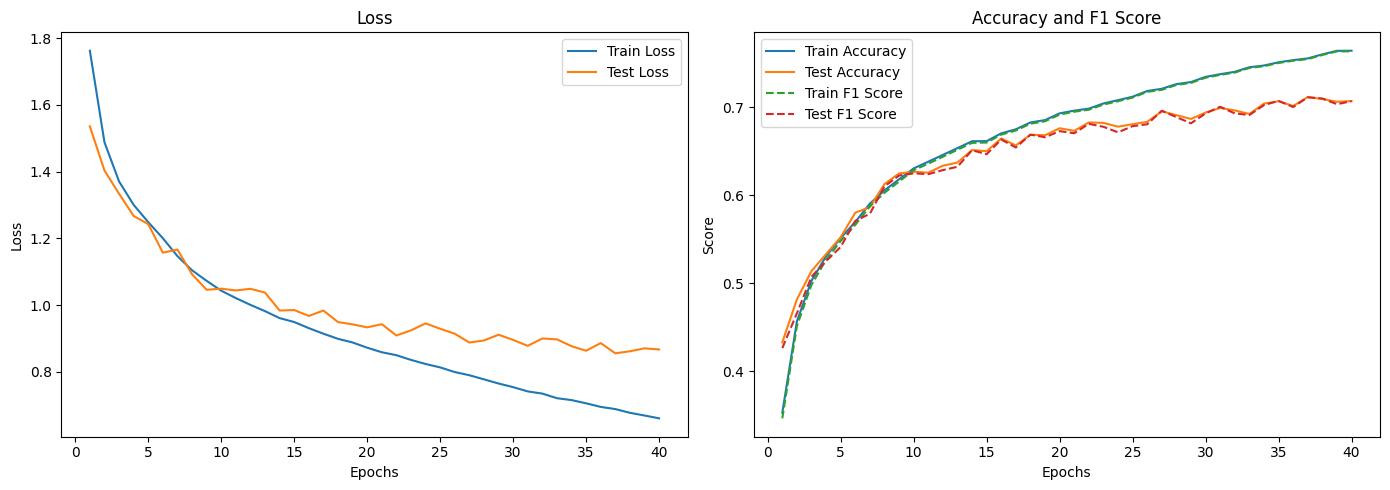

In [15]:
# Train, evaluaciíon y plots para model sin data augmentation
train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, num_epochs)


Se observa que el modelo mejora sus métricas de accuracy y f1-score con cada epoch, mientras que su loss disminuye tanto en el conjunto de train como en el de test. Una buena práctica sería entrenarlo durante algunas épocas más, ya que posiblemente tenga potencial de mejora; sin embargo, se recomienda monitorear de cerca para evitar un posible overfitting

In [17]:
# Definicion de class_names para CIFAR10
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 
    'dog', 'frog', 'horse', 'ship', 'truck']

In [18]:
from sklearn.metrics import classification_report

y_pred = []
y_true = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

    airplane       0.71      0.77      0.74      1000
  automobile       0.89      0.76      0.82      1000
        bird       0.65      0.54      0.59      1000
         cat       0.54      0.55      0.54      1000
        deer       0.59      0.73      0.65      1000
         dog       0.65      0.57      0.61      1000
        frog       0.79      0.75      0.77      1000
       horse       0.72      0.77      0.74      1000
        ship       0.84      0.81      0.82      1000
       truck       0.75      0.82      0.79      1000

    accuracy                           0.71     10000
   macro avg       0.71      0.71      0.71     10000
weighted avg       0.71      0.71      0.71     10000



Se observan buenas métricas de clasificación (precisión, recall, f1-score) para la mayoría de las clases. Sin embargo, las clases "bird", "cat", "deer" y "dog" muestran métricas notablemente más bajas. Esto podría deberse a varios factores, como la posible ambigüedad entre clases al compartir patrones visuales similares, tales como ojos, patas y pelaje, lo que dificulta al modelo diferenciarlas. Además, el nivel de detalle en clases como "deer" y "bird" puede hacer más difícil distinguirlas correctamente, ya que estos detalles pueden generar confusión en el proceso de clasificación.

In [19]:
## Data Augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
])

transform_test= transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
])

# Carga de CIFAR-10 con transformaciones con data augmentation
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


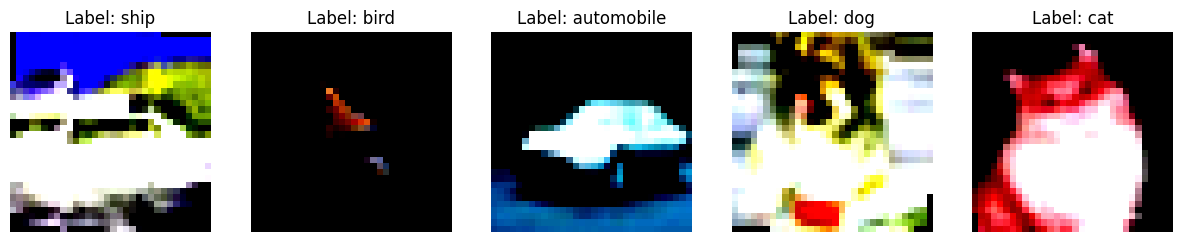

In [20]:
# Revisión de algunas imágenes con data aumentada
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    ax = axes[i]
    ax.imshow(images[i].permute(1, 2, 0).clamp(0, 1))  
    ax.set_title(f'Label: {class_names[labels[i]]}')  
    ax.axis('off')

plt.show()


In [21]:
# Inicializaciones 
num_epochs = 50

model = VisionTransformer(
    img_size = 32 ,
    patch_size = 4 ,
    in_channels= 3 ,
    embed_dim= 256 , 
    num_heads= 8 , 
    ff_dim= 256 , 
    num_layers= 6 ,
    num_classes= 10,
    dropout= 0.3,
    batch_first=True)

# Definición de funciones de loss y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)


model = model.to(device)

c:\Users\matia\anaconda3\envs\cuda_env\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 1.8976, Train Acc: 0.2972, Train F1: 0.2891, Test Loss: 1.6789, Test Acc: 0.3969, Test F1: 0.3735
Epoch [2/50], Train Loss: 1.6778, Train Acc: 0.3881, Train F1: 0.3801, Test Loss: 1.4972, Test Acc: 0.4608, Test F1: 0.4476
Epoch [3/50], Train Loss: 1.5854, Train Acc: 0.4206, Train F1: 0.4135, Test Loss: 1.4690, Test Acc: 0.4750, Test F1: 0.4572
Epoch [4/50], Train Loss: 1.5265, Train Acc: 0.4446, Train F1: 0.4386, Test Loss: 1.3835, Test Acc: 0.4959, Test F1: 0.4850
Epoch [5/50], Train Loss: 1.4814, Train Acc: 0.4628, Train F1: 0.4570, Test Loss: 1.3314, Test Acc: 0.5185, Test F1: 0.5072
Epoch [6/50], Train Loss: 1.4463, Train Acc: 0.4764, Train F1: 0.4711, Test Loss: 1.3386, Test Acc: 0.5240, Test F1: 0.5124
Epoch [7/50], Train Loss: 1.4177, Train Acc: 0.4875, Train F1: 0.4824, Test Loss: 1.3413, Test Acc: 0.5224, Test F1: 0.5053
Epoch [8/50], Train Loss: 1.3960, Train Acc: 0.4982, Train F1: 0.4934, Test Loss: 1.2911, Test Acc: 0.5453, Test F1: 0.5335
Epoch [9

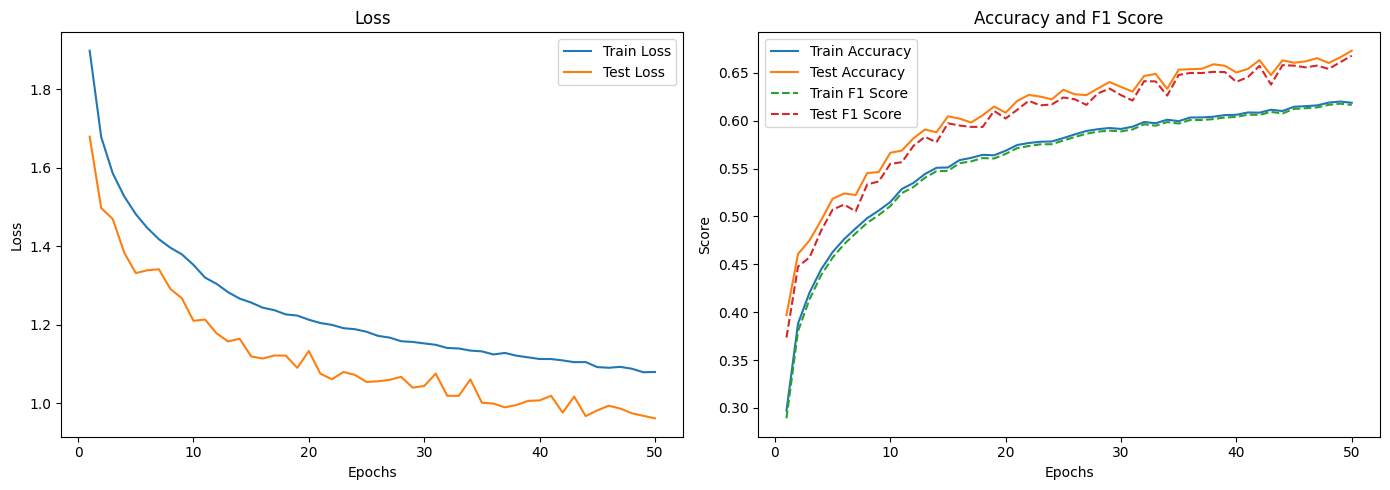

In [22]:
# Entrenamiento, evaluación y plote de model con data augmentation
train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, num_epochs)

In [23]:
y_pred = []
y_true = []

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_pred = np.array(y_pred)
y_true = np.array(y_true)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

    airplane       0.66      0.74      0.70      1000
  automobile       0.80      0.79      0.79      1000
        bird       0.59      0.49      0.54      1000
         cat       0.56      0.44      0.50      1000
        deer       0.59      0.66      0.62      1000
         dog       0.64      0.51      0.57      1000
        frog       0.70      0.78      0.74      1000
       horse       0.70      0.71      0.71      1000
        ship       0.74      0.80      0.77      1000
       truck       0.70      0.80      0.75      1000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000



Se observa que el modelo con data augmentation evoluciona más lentamente que el modelo sin data augmentation, aunque logra un mejor rendimiento en comparación con este último. Las clases "cat", "dog", "deer" y "bird" continúan mostrando un desempeño inferior. Además, las métricas en el conjunto de test son mejores que en train, lo cual podría deberse a que las múltiples transformaciones aplicadas en data augmentation en el conjunto de train pueden distorsionar etiquetas o aumentar la dificultad de aprendizaje, en lugar de aportar mayor variabilidad útil al modelo